<a href="https://colab.research.google.com/github/StevenLevine-NOAA/NBM-Verif/blob/notebooks/Deterministic_Quick_Stats_for_NBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Initialize Notebook Part 1
!pip install -q condacolab #cartopy contextily pyproj pyepsg pygrib netCDF4
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [89]:
#@title Initialize Notebook Part 2
condacolab.check()
#!rm -rf /usr/local/conda-meta/pinned
!mamba install -q cartopy contextily pyproj pyepsg pygrib scikit-learn netCDF4
import numpy as np
import pandas as pd
from urllib.request import urlretrieve, urlopen
import requests
from datetime import datetime, timedelta
import json
from netCDF4 import Dataset
import pygrib
import pyproj
from pyproj import Proj, transform
import os, re, traceback

import warnings
warnings.filterwarnings("ignore")

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from matplotlib.cm import get_cmap
import seaborn as sns

from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error
import math
import zipfile

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
#import contextily as cx
import itertools

✨🍰✨ Everything looks OK!
/usr/local/lib/python3.10/site-packages/conda_package_streaming/package_streaming.py:19: UserWarning: zstandard could not be imported. Running without .conda support.
  warnings.warn("zstandard could not be imported. Running without .conda support.")
/usr/local/lib/python3.10/site-packages/conda_package_handling/api.py:29: UserWarning: Install zstandard Python bindings for .conda support
  _warnings.warn("Install zstandard Python bindings for .conda support")
/usr/local/lib/python3.10/site-packages/conda_package_streaming/package_streaming.py:19: UserWarning: zstandard could not be imported. Running without .conda support.
  warnings.warn("zstandard could not be imported. Running without .conda support.")
/usr/local/lib/python3.10/site-packages/conda_package_handling/api.py:29: UserWarning: Install zstandard Python bindings for .conda support
  _warnings.warn("Install zstandard Python bindings for .conda support")


In [79]:
#@title Case Information and subroutines { display-mode: "form" }
element = "temp" #@param ["temp","maxt","mint","dwpt","wspd","maxwind","maxgust","qpf01","qpf06","qpf12","ceil","vis","gust"]
valid_date = "2023-12-19" #@param {type:"date"}
valid_hour = 18 #@param {type:"slider", min:0, max:23, step:1}
use_stageiv = False #@param {type:"boolean"}
use_nohrsc = False #@param {type:"boolean"}
lookback_hours = 60 #@param {type:"slider", min:0, max:188, setp:3}
region_selection = "CWA" #@param ["WR", "SR", "CR", "ER", "CONUS", "CWA"]
cwa_id = "LWX" #@param {type:"string"}
network_selection = "NWS+RAWS" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
export_csv = True #@param {type:"boolean"}
#@markdown Light or dark theme plots?
plot_style = "dark" #@param ["light", "dark"]

if region_selection == "CONUS":
  region_list = ["WR", "CR", "SR", "ER"]
elif region_selection == "CWA":
  region_list = [cwa_id]
else:
  region_list = [region_selection]

def cwa_list(input_region):
  region_dict ={"WR":"BYZ,BOI,LKN,EKA,FGZ,GGW,TFX,VEF,LOX,MFR,MTR,MSO,PDT,PSR,PIH,PQR,REV,STO,SLC,SGX,HNX,SEW,OTX,TWC",
              "CR":"ABR,BIS,CYS,LOT,DVN,BOU,DMX,DTX,DDC,DLH,FGF,GLD,GJT,GRR,GRB,GID,IND,JKL,EAX,ARX,ILX,LMK,MQT,MKX,MPX,LBF,APX,IWX,OAX,PAH,PUB,UNR,RIW,FSD,SGF,LSX,TOP,ICT",
              "ER":"ALY,LWX,BGM,BOX,BUF,BTV,CAR,CTP,RLX,CHS,ILN,CLE,CAE,GSP,MHX,OKX,PHI,PBZ,GYX,RAH,RNK,AKQ,ILM",
              "SR":"ABQ,AMA,FFC,EWX,BMX,BRO,CRP,EPZ,FWD,HGX,HUN,JAN,JAX,KEY,MRX,LCH,LZK,LUB,MLB,MEG,MFL,MOB,MAF,OHX,LIX,OUN,SJT,SHV,TAE,TBW,TSA"}
  if (input_region in ["WR", "CR", "SR", "ER"]):
    cwas_list = region_dict[input_region]
  else:
    cwas_list = input_region
  return cwas_list

nbm_valid = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=valid_hour)
lookback_range=np.arange(0,lookback_hours,3)
nbm_init = nbm_valid - timedelta(hours=lookback_hours)

current_datetime = datetime.now()

if plot_style=="light":
  background_color = '#f7f7f7'
  text_color = '#121212'
  map_land_color = '#FAFAF8'
  map_water_color = '#D4DBDD'
  map_border_color = 'grey'
elif plot_style=="dark":
  background_color = '#272727'
  text_color = 'white'
  map_land_color = '#414143'
  map_water_color = '#272727'
  #map_border_color = '#3B3B3D'
  map_border_color = 'white'

def K_to_F(kelvin):
  fahrenheit = 1.8*(kelvin-273)+32.
  return fahrenheit

def C_to_F(celsius):
  farenheit=(1.8*celsius)+32.
  return farenheit

def mm_to_in(millimeters):
  inches = millimeters * 0.0393701
  return inches

def mps_to_kts(mps):
  kts = mps * 1.94384
  return kts

def meters_to_in(meters):
  inches = meters*39.3701
  return inches

def miles_to_meters(miles):
  meters = miles*1609.34
  return meters

def ft_to_m(feet):
  meters = feet*0.3048
  return meters

def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)

def download_subset(remote_url, remote_file, local_filename):
  print("   > Downloading a subset of NBM gribs")
  local_file = "nbm/"+local_filename
  if "qmd" in remote_file:
    if element == "maxt":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "mint":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:'
    elif element == "qpf":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
      else:
        search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
    elif element == "maxwind":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 == 0):
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start/24))}-{str(int(nbm_qmd_forecasthour/24))} hour max fcst:'
      else:
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
  elif "core" in remote_file:
    if element == "maxt":
      search_string = f':TMAX:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour max fcst:'
    elif element == "mint":
      search_string = f':TMIN:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour min fcst:'
    elif element == "snow":
      search_string = f':ASNOW:surface:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour acc'
  #print("Search string = ",search_string)
  idx = remote_url+".idx"
  #print("IDX file = " + idx)
  r = requests.get(idx)
  if not r.ok:
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  expr
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
    # n is the line number (starting from 1) so that when we call for
    # `lines[n]` it will give us the next line. (Clear as mud??)
    # Use the compiled regular expression to search the line
    #print(">> Searching throgh this line: " + line)
    if expr.search(line):
      # aka, if the line contains the string we are looking for...
      # Get the beginning byte in the line we found
      parts = line.split(':')
      rangestart = int(parts[1])
      # Get the beginning byte in the next line...
      if n+1 < len(lines):
        # ...if there is a next line
        parts = lines[n].split(':')
        rangeend = int(parts[1])
      else:
        # ...if there isn't a next line, then go to the end of the file.
        rangeend = ''

        # Store the byte-range string in our dictionary,
        # and keep the line information too so we can refer back to it.
      byte_ranges[f'{rangestart}-{rangeend}'] = line
      #print(line)
    #else:
      #print(">>>  Could not find search string!")
  #print(">>  Number of items in byteRange:" + str(len(byte_ranges)))
  for i, (byteRange, line) in enumerate(byte_ranges.items()):

    if i == 0:
      # If we are working on the first item, overwrite the existing file.
      curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
      #print(">>  Adding curl command: " + curl)
    else:
      # If we are working on not the first item, append the existing file.
      curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
      #print("Adding curl command: " + curl)
    #print('>>  Parsing line: ' + line)
    try:
      num, byte, date, var, level, forecast, _ = line.split(':')
    except:
      pass
      #print(">>>  Can't get num/byte/etc from this line, so skipping...")

    #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')
    #print(f'  Downloading GRIB line: variable={var}, level={level}, forecast={forecast}')
    #print("Running the curl command...")
    os.system(curl)

  if os.path.exists(local_file):
    print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
    return local_file
  else:
    print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))

def project_hrap(lon, lat, s4x, s4y):
  lon = float(lon)
  lat = float(lat)

  globe = ccrs.Globe(semimajor_axis=6371200)
  hrap_ccrs = proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=255.0,
                          true_scale_latitude=60.0, globe=globe)
  latlon_ccrs = ccrs.PlateCarree()
  hrap_coords = hrap_ccrs.transform_point(lon,lat,src_crs=latlon_ccrs)
  hrap_idx = ll_to_index(s4x, s4y, hrap_coords[0], hrap_coords[1])

  return hrap_idx

def nohrsc_ll2ij(lon,lat,gridlons,gridlats):
  #for a lat/lon grid
  lon = float(lon)
  lat = float(lat)
  lonidx=(np.abs(lon-gridlons)).argmin()
  latidx=(np.abs(lat-gridlats)).argmin()
  return(latidx,lonidx)

def get_stageiv():
  siv_url = "https://water.weather.gov/precip/downloads/"+nbm_valid.strftime('%Y')+"/"+nbm_valid.strftime('%m')+"/"+nbm_valid.strftime('%d')+"/nws_precip_1day_"+nbm_valid.strftime('%Y%m%d')+"_conus.nc"
  data = urlopen(siv_url).read()
  nc = Dataset('data', memory=data)
  stageIV = nc.variables['observation']
  s4x = nc.variables['x']
  s4y = nc.variables['y']
  return stageIV, s4x, s4y

def get_nohrsc():
  nohrsc_url = "https://www.nohrsc.noaa.gov/snowfall_v2/data/"+nbm_valid.strftime('%Y%m')+"/sfav2_CONUS_24h_"+nbm_valid.strftime('%Y%m%d%H')+".nc"
  data = urlopen(nohrsc_url).read()

  nc = Dataset('data',memory=data)
  snow=np.asarray(nc.variables['Data']) #make lon by lat array (original lat by lon)
  snowlat = np.asarray(nc.variables['lat'])
  snowlon = np.asarray(nc.variables['lon'])
  return snow,snowlon,snowlat

In [80]:
#@title Download and Read Obs
print('Getting obs...')
obs = {}
if os.path.exists("obs"):
  pass
else:
  os.mkdir("obs")

synoptic_token = "62e9269f0a164da1b2415ddcf8f4f29e"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"
nearest_api = "https://api.synopticdata.com/v2/stations/nearesttime?"

# Setup a dictionary for translating a form selection into a something we can pass to mesowest API
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":""} #, "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]
api_token="&token="+synoptic_token

for region in region_list:
  print("   > Grabbing obs for: ", region)
  station_query="&cwa="+cwa_list(region)
  json_name = "obs/Obs_"+element+"_"+nbm_valid.strftime('%Y%m%d%H')+"_"+region+".json"
  if (nbm_valid <= current_datetime):
    if element == "mint" or element == "maxt":
      nbm_start=nbm_valid - timedelta(hours=18)
      vars_query = "&vars=air_temp"
      start_query = "&start="+nbm_start.strftime('%Y%m%d%H%M')
      end_query = "&end="+nbm_valid.strftime('%Y%m%d%H%M')
      if element == "mint":
        ob_stat="minimum"
      else:
        ob_stat="maximum"
      stat_type = "&type="+ob_stat
      network_query = network_string
      api_extras = "&units=temp%7Cf&within=1440&status=active"
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query + api_extras
    elif element == "maxwind":
      nbm_start = nbm_valid - timedelta (days=1)
      vars_query = "&vars=wind_speed"
      start_query = "&start="+nbm_start.strftime('%Y%m%d%H%M')
      end_query = "&end="+nbm_valid.strftime('%Y%m%d%H%M')
      stat_type = "&type=maximum"
      network_query = network_string
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query
    elif element == "qpf":
      if use_stageiv:
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        stageIV, s4xs, s4ys = get_stageiv()
        s4xs, s4ys = np.meshgrid(s4xs, s4ys)
      else:
        nbm_start = nbm_valid - timedelta(days=1)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+nbm_start.strftime('%Y%m%d%H%M')
        end_query = "&end="+nbm_valid.strftime('%Y%m%d%H%M')
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    elif element == "snow":
      if use_nohrsc:
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        snow,snowlon,snowlat = get_nohrsc()
        snowlons,snowlats = np.meshgrid(snowlon,snowlat)
      else:
        nbm_start = nbm_valid - timedelta(days=1)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+nbm_start.strftime('%Y%m%d%H%M')
        end_query = "&end="+nbm_valid.strftime('%Y%m%d%H%M')
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    else: # element == "temp" or element == "dwpt":
      api_extras="&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
      network_query = network_string
      time_query="&attime="+nbm_valid.strftime('%Y%m%d%H%M')+"&within=30"
      if element == "temp":
        vars_query="&vars=air_temp"
      elif element == "dwpt":
        vars_query="&vars=dew_point_temperature"
      elif element == "wspd":
        vars_query="&vars=wind_speed"
      elif element == "gust":
        vars_query="&vars=wind_gust"
      elif element == "vis":
        vars_query="&vars=visibility"
      elif element == "ceil":
        vars_query="&vars=ceiling"
      elif element == "qpf01":
        vars_query="&vars=precip_accum_one_hour"
      elif element == "qpf03":
        vars_query="&vars=precip_accum_three_hour"
      elif element == "qpf06":
        vars_query = "&vars=precip_accum_six_hour"
      elif element == "qpf24":
        vars_query = "&vars=precip_accum_24_hour"
      obs_url = nearest_api + api_token + station_query + vars_query + time_query + api_extras
    print("Obs url: " + obs_url)
    if os.path.exists(json_name):
      print ("Skipping download since JSON file already exists")
      pass
    else:
      urlretrieve(obs_url, json_name)
    #now read the file
    if os.path.exists(json_name):
      with open(json_name) as json_file:
        obs_json = json.load(json_file)
        obs_lats = []
        obs_lons = []
        obs_value = []
        obs_elev = []
        obs_stid = []
        obs_name = []
        for stn in obs_json["STATION"]:
          # print(stn.encode('utf-8'))
          if stn["STID"] is None:
            stid = "N0N3"
          else:
            stid = stn["STID"]
            #print(f'Processing {region} station {stid}')
            name = stn["NAME"]
            if stn["ELEVATION"] and stn["ELEVATION"] is not None:
              elev = stn["ELEVATION"]
            else:
              elev = -999
            lat = stn["LATITUDE"]
            lon = stn["LONGITUDE"]
            if element == "mint" or element=="maxt":
              if 'air_temp_set_1' in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
                if ob_stat in stn['STATISTICS']['air_temp_set_1']: # and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
                  stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(C_to_F(float(stat)))
            elif element == "maxwind":
                if 'wind_speed_set_1' in stn['STATISTICS'] and stn['STATISTICS']['wind_speed_set_1']:
                  if ob_stat in stn['STATISTICS']['wind_speed_set_1']: # and float(stn["LATITUDE"]) != 0.:
                    stat = stn['STATISTICS']['wind_speed_set_1'][ob_stat]
                    obs_stid.append(str(stid))
                    obs_name.append(str(name))
                    obs_elev.append(float(elev))
                    obs_lats.append(float(lat))
                    obs_lons.append(float(lon))
                    obs_value.append(mps_to_kts(float(stat)))
            elif (element == "qpf"):
                if (stn["STATUS"] == "ACTIVE"): # and float(stn["LATITUDE"]) < 50.924 and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  if use_stageiv:
                    coords = project_hrap(lon, lat, s4xs, s4ys)
                    siv_value = float(stageIV[coords])
                    if (siv_value >= 0.01):
                      obs_value.append(siv_value)
                    else:
                      obs_value.append(0.0)
                  else:
                    if "precipitation" in stn["OBSERVATIONS"]:
                      if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                        ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                        if ptotal >= 0.005:
                          obs_value.append(ptotal)
                        else:
                          obs_value.append(0.0)
                      else:
                        obs_value.append(np.nan)
                    else:
                      obs_value.append(np.nan)
            elif (element == "snow"):
                if stn["STATUS"] == "ACTIVE": # and float(stn["LATITUDE"]) < 50.924)and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                    obs_stid.append(str(stid))
                    obs_name.append(str(name))
                    obs_elev.append(float(elev))
                    obs_lats.append(float(lat))
                    obs_lons.append(float(lon))
                    if use_nohrsc:
                      coords = nohrsc_ll2ij(lon,lat,snowlon,snowlat)
                      nohrsc_value = meters_to_in(float(snow[coords]))
                      if nohrsc_value >= 0.005:
                        obs_value.append(nohrsc_value)
                      elif nohrsc_value < 0.0:
                        obs_value.append(np.nan)
                      else:
                        obs_value.append(0.0)
                    else:
                      raise Exception("Still not able to process individual snow obs!")
            elif (element == "temp"):
              if stn["STATUS"] == "ACTIVE":
                if 'air_temp_value_1' in stn['OBSERVATIONS'] and stn['OBSERVATIONS']['air_temp_value_1']:
                  value=stn['OBSERVATIONS']['air_temp_value_1']['value']
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(C_to_F(float(value)))
            elif element == "wspd":
              if stn["STATUS"] == "ACTIVE":
                if 'wind_speed_value_1' in stn['OBSERVATIONS'] and stn['OBSERVATIONS']['wind_speed_value_1']:
                  value=stn['OBSERVATIONS']['wind_speed_value_1']['value']
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(mps_to_kts(float(value)))
            elif element == "gust":
              if stn["STATUS"] == "ACTIVE":
                if 'wind_gust_value_1' in stn['OBSERVATIONS'] and stn['OBSERVATIONS']['wind_gust_value_1']:
                  value=stn['OBSERVATIONS']['wind_gust_value_1']['value']
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(mps_to_kts(float(value)))
            elif element == "dwpt":
              if stn["STATUS"] == "ACTIVE":
                if 'dew_point_value_1' in stn['OBSERVATIONS'] and stn['OBSERVATIONS']['dew_point_value_1']:
                  value=stn['OBSERVATIONS']['dew_point_value_1']['value']
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(C_to_F(float(value)))
            elif element == "vis":
              if stn["STATUS"] == "ACTIVE":
                if 'visibility_value_1' in stn['OBSERVATIONS'] and stn['OBSERVATIONS']['visiblity_value_1']:
                  value=stn['OBSERVATIONS']['visibility_value_1']['value']
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(miles_to_meters(float(value)))
            elif element == "ceil":
              if stn['STATUS'] == "ACTIVE":
                if 'ceiling_value_1' in stn['OBSERVATIONS'] and stn['OBSERVATIONS']['ceiling_value_1']:
                  value=stn['OBSERVATIONS']['ceiling_value_1']['value']
                  obs_stid.append(str(stid))
                  obs_name.append(str(name))
                  obs_elev.append(float(elev))
                  obs_lats.append(float(lat))
                  obs_lons.append(float(lon))
                  obs_value.append(float(value))
      csv_name = "obs_"+element+"_"+region+"_"+nbm_valid.strftime("%Y%m%d%H")+".csv"
      obs[region] = pd.DataFrame()
      obs[region]["stid"] = obs_stid
      obs[region]["name"] = obs_name
      obs[region]["elevation"] = obs_elev
      obs[region]["lat"] = obs_lats
      obs[region]["lon"] = obs_lons
      obs[region]["ob_"+element] = obs_value
      obs[region].dropna(inplace=True)
      obs[region].to_csv(csv_name)
    else:
      raise Exception ("Can't find obs file after download attempt: " + json_name)
  else:
    raise Exception ("Valid time is in the future: Cannot retrieve obs!")

Getting obs...
   > Grabbing obs for:  LWX
Obs url: https://api.synopticdata.com/v2/stations/nearesttime?&token=62e9269f0a164da1b2415ddcf8f4f29e&cwa=LWX&vars=air_temp&attime=202312191800&within=30&fields=status,latitude,longitude,name,elevation&obtimezone=utc
Skipping download since JSON file already exists


In [81]:
#@title Download NBM Grids
if "AR" in region_list or "AJK" in region_list or "ARH" in region_list or "AFC" in region_list:
  rg="ak"
elif "HFO" in region_list:
  rg="hi"
elif "SJU" in region_list:
  rg="pr"
else:
  rg="co"

nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') +"/"+nbm_init.strftime('%H')+"/"

core_vars = ["maxt","mint","temp","dwpt","ceil","vis","gust","wspd"]
#if (element == "qpf"):
#  detr_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(lookback_hours):03}.{rg}.grib2'
#  detr_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}.f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset.grib2'
#  detr_url = nbm_url_base+"qmd/"+detr_file
#
#elif any(te in element for te in core_vars):
detr_file = f"blend.t{int(nbm_init.strftime('%H')):02}z.core.f{int(lookback_hours):03}.{rg}.grib2"
#detr_file_subset = f"blend.t{int(nbm_init.strftime('%H')):02}z.core.{nbm_init_filen}.f{int(lookback_hours):03}.{rg}.{element}_subset.grib2"
detr_url = nbm_url_base+"core/"+detr_file

if os.path.exists("nbm/"+detr_file):
  print("  > NBM Deterministic file already downloaded")
else:
  print("  > Getting NBM core file")
  if os.path.exists("nbm"):
    pass
  else:
    os.mkdir("nbm")
  os.system(f' curl -s {detr_url} > nbm/{detr_file}')
nbmd = pygrib.open("nbm/"+detr_file)
if element == "temp":
  deterministic = nbmd.select(name="2 metre temperature",typeOfLevel="heightAboveGround",level=2,forecastTime=lookback_hours)[0]
elif element == "dwpt":
  deterministic = nbmd.select(name="2 metre dew point",typeOfLevel="heightAboveGround",level=2,forecastTime=lookback_hours)[0]
elif element == "wspd":
  determinisitc = nbmd.select(name="10 metre wind speed",typeOfLevel="heightAboveGround",level=10,forecastTime=lookback_hours)[0]
elif element == "gust":
  deterministic = nbmd.select(name="10 metre wind speed (gust)",typeOfLevel="heightAboveGround",level=10,forecastTime=lookback_hours)[0]
elif element == "ceil":
  deterministic = nbmd.select(name="Ceiling",typeOfLevel="cloudCeiling",forecastTime=lookback_hours)[0]
  if deterministic.is_missing(probabilityType):
    pass
  else:
    raise Exception ("Probabilties found when deterministic expected for ceiling")
elif element == "vis":
  determinisitc = nbmd.select(name="Visibility",typeOfLevel="surface",forecastTime=lookback_hours)[0]
  if determinisitc.is_missing(probabilityType):
    pass
  else:
    raise Exception ("Probabilities found when determinisitc expected for visiblity")
elif element == "qpf01":
  determinisitc = nbmd.select(name="Total Precipitation",typeOfLevel="surface",typeOfStatisticalProcessing=1,lengthOfTimeRange=1)[0]
elif element == "qpf06":
  determinisitc = nbmd.select(name="Total Precipitation",typeOfLevel="surface",typeOfStatisticalProcessing=1,lengthOfTimeRange=6)[0]
elif element == "qpf12":
  determinisitc = nbmd.select(name="Total Precipitation",typeOfLevel="surface",typeOfStatisticalProcessing=1,lengthOfTimeRange=12)[0]

if element in ["temp","dwpt","maxt","mint"]:
  deterministic_values=K_to_F(deterministic.values)
elif element in ["qpf01","qpf06","qpf12","qpf24"]:
  deterministic_values=mm_to_in(deterministic.values)
elif element in ["wspd","gust","maxspeed","maxgust"]:
  deterministic_values=mps_to_kts(deterministic.values)
else:
  deterministic_values=deterministic.values
nbmlats, nbmlons = deterministic.latlons()
nbmd.close()

  > NBM Deterministic file already downloaded


In [82]:
#@title Interpolate Grid to Obs

for region in region_list:
  point_lats = obs[region]["lat"].values
  point_lons = obs[region]["lon"].values
  detr_values = []
  nbm_fidx = []
  for i in range(0,len(point_lats)):
    coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
    fcst_value = deterministic_values[coords]
    nbm_fidx.append(coords)
    detr_values.append(fcst_value)
  obs[region]["NBM_fidx"] = nbm_fidx
  obs[region]["Forecast"] = detr_values
  obs[region]["O-F"] = obs[region]["ob_"+element] - obs[region]["Forecast"]
  csv_name=f'obs_and_fcsts.{element}.{nbm_init.strftime("%Y%m%d")}.t{nbm_init.strftime("%H")}z.f{int(lookback_hours):03}.{region}.csv'
  obs[region].to_csv(csv_name)
  print(f'   > Created and saved {csv_name}')

   > Created and saved obs_and_fcsts.temp.20231217.t06z.f060.LWX.csv


In [83]:
#@title Make Statistics

oblist=obs[region]["ob_"+element]
fcstlist=obs[region]["Forecast"]

RMSE=mean_squared_error(oblist,fcstlist)
MAE=mean_absolute_error(oblist,fcstlist)
BIAS=(np.mean(oblist)-np.mean(fcstlist))/(len(obs[region].index))
VARIANCE=explained_variance_score(oblist,fcstlist)

print(f'RMSE: {RMSE}')
print(f'MAE: {MAE}')
print(f'BIAS: {BIAS}')
print(f'VARIANCE: {VARIANCE}')

RMSE: 2.309527889341495
MAE: 1.2577112409607532
BIAS: -0.001470608617015213
VARIANCE: 0.844853692731495


   >> Cannot plot CWA boundaries
   >> Extracted county shape files


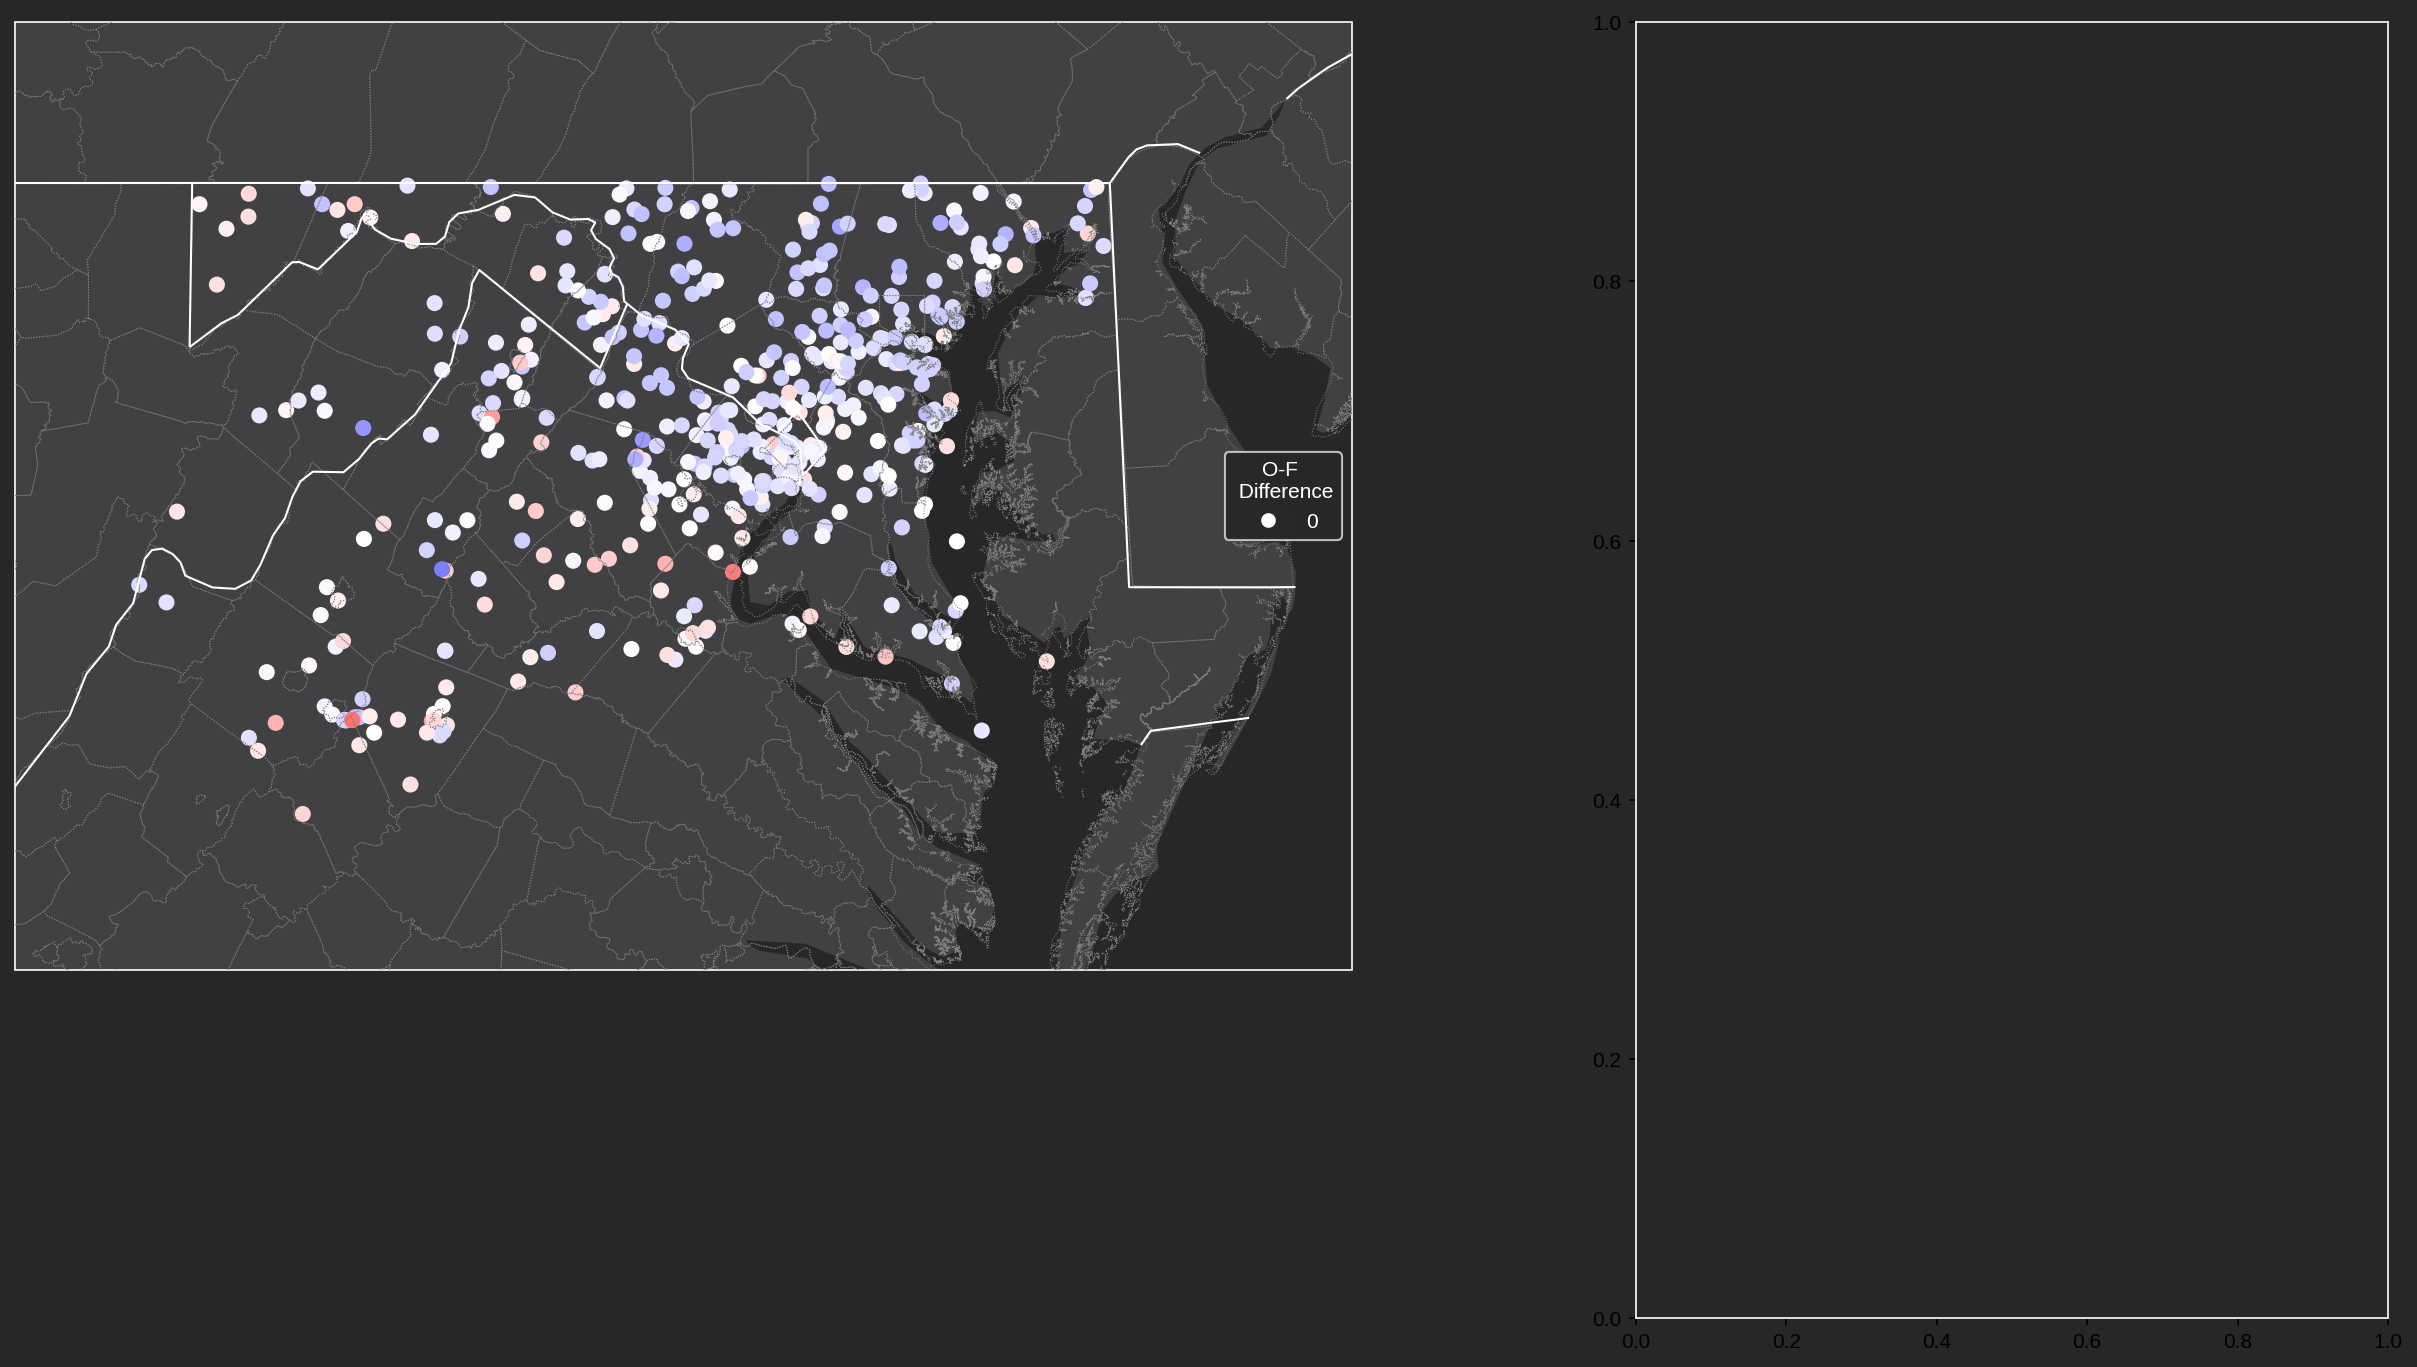

In [92]:
#@title Generate Plot

matplotlib.rc('axes',facecolor=background_color,edgecolor=text_color)
fig_valid_date=nbm_valid.strftime("%HZ %m-%d-%Y")
fcst_date=nbm_init.strftime("%HZ %m-%d%-Y")

compare_var="O-F"

#set colors/ranges by variable
if element in ["temp","dwpt","maxt","mint"]:
  cmap=get_cmap("bwr")
  vmin=-10.0
  vmax=10.0
elif element in ["qpf01","qpf06","qpf12","qpf24"]:
  cmap=get_cmap("BrBG")
  vmin=-2.0
  vmax=2.0
elif element in ["ceil","vis"]:
  cmap=get_cmap("RdYlGn")
  vmin=-5000.0
  vmax=5000.0
else:
  raise Exception ("Notebook not configured for this variable yet: " + element)

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

if (region_selection == "WR"):
      west = -126.917
      south = 30.586
      east = -102.740
      north = 49.755
      width, height = (16,9)
      width_ratios = [9,8]
      lloc = "lower right"
elif (region_selection == "CR"):
      west = -111.534
      south = 33.295
      east = -81.723
      north = 49.755
      width, height = (16,7)
      width_ratios = [9,7]
      lloc = "lower center"
elif (region_selection == "ER"):
      west = -86.129
      south = 31.223
      east = -66.465
      north = 47.676
      width, height = (16,7.25)
      width_ratios = [6.9,9.5]
      lloc = "lower right"
elif (region_selection == "SR"):
    west = -109.758
    south = 23.313
    east = -79.247
    north = 36.899
    width, height = (16,5.6)
    width_ratios = [10,6]
    lloc = "lower center"
else: #if (region_selection == "CWA"):
    west = np.min(obs[region]["lon"]) - 0.5
    south = np.min(obs[region]["lat"]) - 0.5
    east = np.max(obs[region]["lon"]) + 1.0
    north = np.max(obs[region]["lat"]) + 0.5
    width, height = (16,9)
    ratioxy = 16./9.
    width_ratios = [ratioxy, 1]
    lloc = "center right"


#width, height = (16,9)
fig = plt.figure(constrained_layout=True, figsize=(width,height), facecolor=background_color, frameon=True, dpi=150)
if (region_selection == "CWA"):
  dataframeid = cwa_id
else:
  dataframeid = region_selection
#ratioxy = 16./9.
#width_ratios = [ratioxy, 1]
grid = fig.add_gridspec(1,2, hspace=0.2, width_ratios=width_ratios, height_ratios = [1], wspace=0.2)
ax1 = fig.add_subplot(grid[0,0], projection=ccrs.Mercator())
#ax1 = fig.add_subplot(grid[0,0], projection=ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25,25)))
ax2 = fig.add_subplot(grid[0,1], )

lats = obs[dataframeid]["lat"].values
lons = obs[dataframeid]["lon"].values
point_data = obs[dataframeid][compare_var].values
mean = obs[dataframeid][compare_var].mean()
median = obs[dataframeid][compare_var].median()
#mode = obs[dataframeid][compare_var].mode().values[0]
proj = ccrs.PlateCarree()
numcols=(abs(np.amax(point_data) - np.amin(point_data))//10) + 1

ax1.set_anchor('N')
ax1.set_facecolor(background_color)
ax1.set_extent([west, east, south, north], crs=proj)
#ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
#ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2)
#ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=5))
#ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border, facecolor='none', linewidth=1, zorder=5))
#cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj, zorder=2, vmin=vmin, vmax=vmax)

if region_selection in ("CR","SR"):
    handles, labels = scatter.legend_elements(num=numcols)
    legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
else:
    legend1 = ax1.legend(*scatter.legend_elements(num=numcols),
                      loc=lloc, title=f'{compare_var} \n Difference', fancybox=True)
plt.setp(legend1.get_title(), multialignment='center', color=text_color)
for text in legend1.get_texts():
  text.set_color(text_color)
ax1.add_artist(legend1)

try:
  if os.path.exists("shp/w_22mr22.shp"):
    pass
  else:
    cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
    os.mkdir("shp")
    urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
    print("   >>> Downloaded CWA file")
    #!unzip shp/nws_cwa_outlines.zip -d shp
  with zipfile.ZipFile("shp/nws_cwa_outlines.zip", 'r') as zip_ref:
    zip_ref.extractall("shp")
    wa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1, linestyle='-', zorder=4)
    ax1.add_feature(cwa_feature)
except:
  print("   >> Cannot plot CWA boundaries")
#  if county_outline:
try:
  if os.path.exists("shp/c_08mr23.shp"):
    pass
  else:
    county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip"
  if os.path.exists("shp/counties.zip"):
    pass
  else:
    if os.path.exists("shp"):
      pass
    else:
      os.mkdir("shp")
    urlretrieve(county_url, "shp/counties.zip")
    print("   >> Downloaded county zip file")

  with zipfile.ZipFile("shp/counties.zip",'r') as cty_ref:
    cty_ref.extractall("shp")
    print("   >> Extracted county shape files")
    cty_feature = ShapelyFeature(Reader("shp/c_08mr23.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
    ax1.add_feature(cty_feature)
except:
  print("   >> Cannot plot county boundaries.")